# Predecir métricas de performance de jugares de Football

## Descripción del data set

En este ejercicio tienes una misión, predecir el "Overall Performance" de los jugadores de Football dadas algunas variables independientes como lo son algunas capacidades físicas.

Coloca el data set `fifa19_players.csv` en una carpeta llamada `data`. Después sigue las instrucciones en este notebook para dar solución a todos los problemas

## Importa Librerías importantes y carga los datos

In [29]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [32]:
data = pd.read_csv('data/fifa19_players.csv')
data.head()

,Unnamed: 0,Unnamed: 0.1,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


## Expolora el set de datos

In [33]:
# Explora la forma del data set
def print_shape(data):
    """ Function to print the the number of features and observations in a data set
      
        Args:  
        data pandas data frame containing the input variables
    """
    print("Observations: {} \nFeatures: {}".format(data.shape[0], data.shape[1]))
print_shape(data)

Observations: 18159 
Features: 90


In [34]:
# Checa si hay filas duplicadas
print("Duplicate rows: {}".format(np.sum(data.duplicated(subset=None, keep='first'))))

Duplicate rows: 0


In [35]:
# Checa los tipos de datos en el set de datos
def print_number_dtypes(data):
    """ Function to print the the number of features per data type in a data set
      
        Args:  
        data pandas data frame containing the input variables
    """
    # Determine data types in a data frame
    data_types = pd.DataFrame(data.dtypes)\
                   .reset_index()
    
    # Count how many variables per data type
    data_types.columns = ['feature_name', 'data_type']
    data_types = data_types.sort_values(['feature_name'])
    data_types_count = data_types.groupby(['data_type'])\
                             .count()\
                             .reset_index()
    data_types_count.columns = ['data_type', 'number']
    
    # Print number of variables per data type
    dash = '-' * 35
    print(dash)
    print('{:<15s}{:<3s}'.format('Data type','Number of features'))
    print(dash)
    for i in range(data_types_count.shape[0]):
        print('{:<15s}{:<3f}'.format(str(data_types_count.data_type[i]), data_types_count.number[i]))
    print(dash)
    return data_types

# Imprime tipo de datos
data_types = print_number_dtypes(data)

-----------------------------------
Data type      Number of features
-----------------------------------
int64          7.000000
float64        38.000000
object         45.000000
-----------------------------------


---
La variable "Overall" contiene el score de performance general de cada jugador profesional. Explora esta variable con las distintas formas que vimos en clase. Hint: ¿Qué gráficos podemos usar para analizar la distribución de variables continuas?
También determina distintos estadísticos descriptivos

¿Qué distribución sigue la variable "Overall"? 

¿Qué explicación podrías dar con respecto a la distribución que sigue la variable?

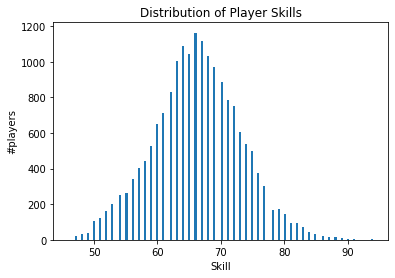

In [41]:
# Checar la distribución de la variable "Overall" (Histograma)
plt.xlabel('Skill')
plt.ylabel('#players')
plt.title('Distribution of Player Skills')
plt.hist(data['Overall'], bins=150)
plt.show()

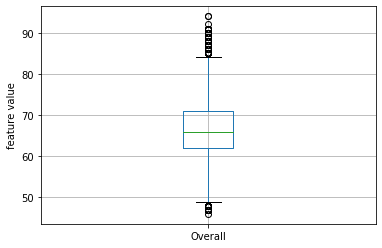

In [42]:
# Checar la distribución de la variable "Overall" (Box plot)
data.boxplot(column='Overall')
plt.ylabel('feature value')
plt.show()

## Preprocesamiento de datos

Para predecir el performance general de jugadores profesionales de football, vamos a concentrarnos en las siguientes variables. Elimina el resto

In [43]:
skills = ['Overall', 'Weak Foot', 'Skill Moves', 'Work Rate', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes']

In [44]:
# Filtra el set de datos con las variables definidas en la celda anterior
data = data[skills]

El modelo de aprendizaje de máquina que vamos a entrenar solo puede tener variables de entrada númericas. Revisa cuántas variables tipo **object** tienes en el nuevo set de datos. 

In [45]:
# Imprime tipo de datos
data_types = print_number_dtypes(data)

-----------------------------------
Data type      Number of features
-----------------------------------
int64          1.000000
float64        36.000000
object         1.000000
-----------------------------------


La variable catégorica 'Work Rate' refiere al esfuerzo que cada jugador pone para atacar y defender en un juego. Determina las categorías que tiene esta variable y después utiliza la siguiente función para transformar esta variable categórica en dos variables "númericas". 

In [46]:
# Determina las categorías únicas que presenta la variable "Work Rate"
data['Work Rate'].unique()

array(['Medium/ Medium', 'High/ Low', 'High/ Medium', 'High/ High',
       'Medium/ High', 'Medium/ Low', 'Low/ High', 'Low/ Medium',
       'Low/ Low'], dtype=object)

In [47]:
rate_to_int = {'Low':0, 'Medium':1, 'High':2}
def extract_work_rate(p):
    if not type(p['Work Rate']) == str:
        attack = np.nan
        defense = np.nan
    else:
        attack, defense = p['Work Rate'].split('/ ')
        attack = rate_to_int[attack]
        defense = rate_to_int[defense]
    
    p['attack_work_rate'] = attack
    p['defense_work_rate'] = defense
    
    return p

data = data.apply(extract_work_rate, axis=1)
data = data.drop(columns=['Work Rate'])

In [48]:
# Echa un vistazo a las variables creadas a partir de "Work Rate"
data.head()

,Overall,Weak Foot,Skill Moves,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,attack_work_rate,defense_work_rate
0,94,4.0,4.0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,...,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,1,1
1,94,4.0,5.0,84.0,94.0,89.0,81.0,87.0,88.0,81.0,...,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,2,0
2,92,5.0,5.0,79.0,87.0,62.0,84.0,84.0,96.0,88.0,...,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,2,1
3,91,3.0,1.0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,...,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,1,1
4,91,5.0,4.0,93.0,82.0,55.0,92.0,82.0,86.0,85.0,...,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,2,2


Es importante que nuestro set de entrenamiento no contenga valores faltantes. Averigua si algunas de las variables en el set de datos que estás utilizando presenta valores nulos. En caso de ser cierto, preprocesa el set de datos para ya no tenerlos. Hint: utiliza alguna de las formas vistas en clase (reemplazar con media, mediana, etc). Justifica el método que decidas usar

In [49]:
# Primero averigua cuál o cuáles variables presentan valores nulos
data.columns[data.isnull().any()].tolist()

['SprintSpeed']

In [50]:
# Describe los principales estadísticos de la(s) variable(s) que contiene(n) valores nulos para ayudar en tu decisión
data['SprintSpeed'].describe()

count    18153.000000
mean        64.728309
std         14.648602
min         12.000000
25%         57.000000
50%         67.000000
75%         75.000000
max         96.000000
Name: SprintSpeed, dtype: float64

¿Cuál es la mejor forma de imputar los valores faltantes en la(s) variable(s)?

In [51]:
# Imputa valores missing en la(s) variable(s) que contiene(n) valores missing
data.fillna(data.mean(), inplace=True)

In [52]:
# Revisa los rangos de las distintas variables independientes
pd.concat([data.min().rename('min'), data.max().rename('max')], axis=1)

,min,max
Overall,46.00,94.00
Weak Foot,1.00,5.00
Skill Moves,1.00,5.00
Crossing,5.00,93.00
Finishing,2.00,95.00
HeadingAccuracy,4.00,94.00
ShortPassing,7.00,93.00
Volleys,4.00,90.00
Dribbling,4.00,97.00
Curve,6.00,94.00


Las variables tienen escalas distintas... ¿Qué podríamos hacer?

In [53]:
# Normaliza los valores de las variables independientes
data_values = data.values
min_max_scaler = preprocessing.MinMaxScaler()
data_values = min_max_scaler.fit_transform(data_values)
data = pd.DataFrame(data_values, columns=data.columns)

In [54]:
# Revisa los rangos de las distintas variables independientes después de ser normalizadas
pd.concat([data.min().rename('min'), data.max().rename('max')], axis=1)

,min,max
Overall,0.0,1.0
Weak Foot,0.0,1.0
Skill Moves,0.0,1.0
Crossing,0.0,1.0
Finishing,0.0,1.0
HeadingAccuracy,0.0,1.0
ShortPassing,0.0,1.0
Volleys,0.0,1.0
Dribbling,0.0,1.0
Curve,0.0,1.0


## Construye un modelo de regresión con un término de regularización L2. Aka: Regresión Ridge

Para este primer modelo solo utilizarás el siguiente conjunto de variables (skills atléticos)

In [ ]:
athletic_skills = ['Overall', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'Jumping', 'Stamina', 'Strength']

Tienes que predecir la variable **Overall**, por lo tanto puedes crear un modelo de regresión Ridge. Donde $y$ es la variable target, $X$ es la matriz de variables independientes que corresponden a todos los skills atléticos de los jugadores de football, $w$ es el vector de parámetros a estimar tal que $y = f_{W}(X) + \epsilon$, y $\alpha$ es el hyper-parametro del término regularizador.

$$||y-Xw||_2^2 + \alpha ||w||_2^2,$$

Tu deber aquí es el encontrar el parámetro $\alpha$ óptimo para la regresión Ridge. Recuerda partir los datos y utilizar K-Fold Cross-Validation para tener el modelo que mejor generalice a datos nuevos

In [ ]:
# Filtra el set de datos tal que solo contenga las variables independientes referentes a skills atléticos y la variable target "Overall"
data_athletic = data[athletic_skills]

# Define la variable target (Overall Performance)
y_athletic = data_athletic.values[:,0]

# Define el conjunto de variables independientes
X_athletic = data_athletic.values[:,1:]

# Utiliza la función de sklearn para partir los datos en set de entrenamiento y validación
# 70% train, 30% test, utiliza una semilla para poder replicar resultados (busca en la documentación de sklearn como hacer esto)
X_train_athletic, X_test_athletic, y_train_athletic, y_test_athletic = train_test_split(X_athletic, y_athletic, test_size=0.3, random_state=1)

Sigue el siguiente algoritmo para optimizar $\alpha$ en el intervalo [0, 2000]. Utiliza el error cuadrático medio como la función de costo a optimizar. 

* Define listas para guardar los valores de los distintos alphas a probar y el error que cada una de ellas va generando
* Define el valor inicial para alpha
* Ciclo iterativo para alpha en el intervalo [0, 2000]
    * Guarda el objeto Ridge de sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) en un objeto de python (toma en cuenta que este objeto tiene que cambiar el valor de alpha en cada iteración)
    * Guarda el valor actual de alpha en la lista definida anteriormente
    * Calcula el valor de MSE utilizando la función de cross validation de sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Ten cuidado al seleccionar la métrica a utilizar. Recuerda que al final de cada ejecución de cross validation, tenemos que calcular el promedio de todos los errores para poder obtener la estimación de la generalización del error
    * Guarda el valor actual de MSE en la lista definida anteriormente
* Determina el alpha óptimo. Ten cuidado, la métrica utilizada para la función cross_val_score es crucial para poder determinar cómo se ve el alpha óptimo (máximo o mínimo)
* Regresa el valor óptimo para alpha


In [55]:
# Define aquí el proceso para determinar el alpha óptimo a través de ejecutar un algoritmo de validación cruzada con K = 5
alphas = []
scores = []
# hyperparameter optimization
def hyper_ridge(X, y):
    best_alpha = 0
    highest_score = float('-inf')
    for alpha in np.linspace(0,2000,2001):
        ridge_reg = Ridge(alpha=alpha)
        alphas.append(alpha)
        curr_score = cross_val_score(ridge_reg, X_train_athletic, y_train_athletic, cv=5, scoring='neg_mean_squared_error').mean()
        scores.append(curr_score)
        if curr_score > highest_score:
            highest_score = curr_score
            best_alpha = alpha
    return best_alpha

# Determina el mejor alpha para la regresión Ridge
alpha_athletic = hyper_ridge(X_train_athletic, y_train_athletic)

# Entrena un modelo de regresión Ridge con el alpha óptimo
ridge_reg_athletic = Ridge(alpha=alpha_athletic)
ridge_reg_athletic.fit(X_train_athletic, y_train_athletic)

Ridge(alpha=0.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

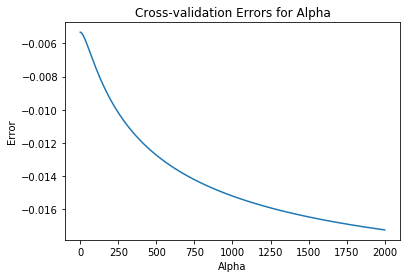

In [56]:
# Gráfica la lista de errores vs el valor de alpha
plt.xlabel('Alpha')
plt.ylabel('Error')
plt.title('Cross-validation Errors for Alpha')
plt.plot(alphas, scores)
plt.show()

In [57]:
# Determina el score R^2 y el MSE (Recuerda hacerlo en el set de datos de test)
print("R²: {0}, MSE: {1}".format(round(ridge_reg_athletic.score(X_test_athletic, y_test_athletic), 5), round(mean_squared_error(y_test_athletic,ridge_reg_athletic.predict(X_test_athletic)),5)))

R²: 0.73493, MSE: 0.00542


## Entrena un segundo modelo utilizando todas las variables relevantes

¿Qué pasa si ahora utilizamos todas las variables de la lista skills para entrenar el modelo (set de datos filtrado inicialmente)?


In [59]:
# Define el conjunto de variables independientes
X = data.values[:,1:]

# Define la variable target (Overall Performance)
y = data.values[:,0]

# Utiliza la función de sklearn para partir los datos en set de entrenamiento y validación
# 70% train, 30% test, utiliza una semilla para poder replicar resultados (busca en la documentación de sklearn como hacer esto)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [60]:
# Determina el mejor alpha para la regresión Ridge
alpha = hyper_ridge(X_train, y_train)

# Entrena un modelo de regresión Ridge con el alpha óptimo
ridge_reg = Ridge(alpha=alpha)
ridge_reg.fit(X_train, y_train)

# Determina el score R^2 y el MSE (Recuerda hacerlo en el set de datos de test)
print("R²: {0}, MSE: {1}".format(round(ridge_reg.score(X_test, y_test), 5), round(mean_squared_error(y_test,ridge_reg.predict(X_test)),5)))

R²: 0.86382, MSE: 0.00279


## Selecciona el mejor modelo
Investiga en internet en que consiste el método de Bootstrap e intenta implementarlo para determinar cuál de los dos modelos anteriores es mejor para predecir el performance general de jugadores de football


In [61]:
num_records = y.shape[0]
bootstrap_errors = []
bootstrap_errors_athletic = []
for i in range(1000):
    train_indices = np.random.choice(range(num_records), num_records, replace=True)
    test_indices = np.setdiff1d(range(num_records), train_indices)
    X_train_b, y_train_b = X[train_indices], y[train_indices]
    X_test_b, y_test_b = X[test_indices], y[test_indices]
    ridge_reg.fit(X_train_b, y_train_b)
    bootstrap_errors.append(mean_squared_error(y_test_b, ridge_reg.predict(X_test_b)))
    
    X_train_b, y_train_b = X_athletic[train_indices], y_athletic[train_indices]
    X_test_b, y_test_b = X_athletic[test_indices], y_athletic[test_indices]
    ridge_reg_athletic.fit(X_train_b, y_train_b)
    bootstrap_errors_athletic.append(mean_squared_error(y_test_b, ridge_reg_athletic.predict(X_test_b)))
    
bootstrap_errors_sorted = np.sort(bootstrap_errors)
bootstrap_errors_sorted_athletic = np.sort(bootstrap_errors_athletic)
print('95% CIs')
print('First model: [{:f}, {:f}]'.format(bootstrap_errors_sorted_athletic[25], bootstrap_errors_sorted_athletic[975]))
print('Second model: [{:f}, {:f}]'.format(bootstrap_errors_sorted[25], bootstrap_errors_sorted[975]))

95% CIs
First model: [0.005206, 0.005513]
Second model: [0.002727, 0.002892]


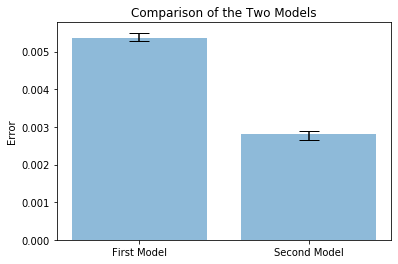

In [62]:
mean_error_athletic = bootstrap_errors_sorted_athletic.mean()
mean_error = bootstrap_errors_sorted.mean()
deviation_athletic = bootstrap_errors_sorted_athletic - mean_error_athletic
deviation = bootstrap_errors_sorted - mean_error
xpos = [0,1]
fig, ax = plt.bar(xpos, [mean_error_athletic, mean_error], yerr=[[deviation_athletic[25], deviation_athletic[975]], [deviation[25], deviation[975]]], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.xticks(xpos, ('First Model', 'Second Model'))
plt.ylabel('Error')
plt.title('Comparison of the Two Models')
plt.show()